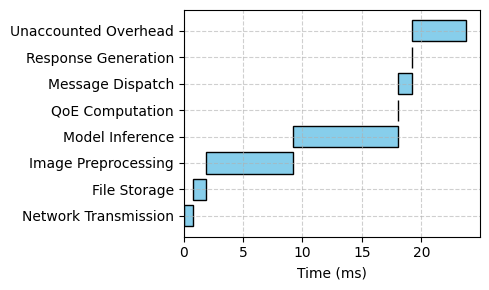

\begin{table} [H]
\centering
\caption{Latency Breakdown ()}
\begin{tabular}{|l|p{2cm}|p{2cm}|}
\hline
\textbf{Component} & \textbf{Latency (ms)} & \textbf{Percent (\%)} \\ \hline
Network Transmission & 0.787 & 3.31 \\ \hline
File Storage & 1.057 & 4.45 \\ \hline
Image Preprocessing & 7.366 & 31.01 \\ \hline
Model Inference & 8.854 & 37.27 \\ \hline
QoE Computation & 0.008 & 0.03 \\ \hline
Message Dispatch & 1.122 & 4.72 \\ \hline
Response Generation & 0.044 & 0.19 \\ \hline
Unaccounted Overhead & 4.517 & 19.01 \\ \hline
\end{tabular}
\end{table}


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from parso.pgen2.generator import DFAPlan


def analyze_and_visualize_latencies(df):
    # Analyze request latencies
    df["Network Transmission"] = df["network_time"]
    df["File Storage"] = (df["image_save_time"] - df["server_receive_time"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_time"] - df["image_save_time"]) * 1000
    df["Model Inference"] = (df["image_predicted_time"] - df["image_preprocessed_time"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_time"] - df["image_predicted_time"]) * 1000
    df["Message Dispatch"] = (df["event_produced_time"] - df["qoe_computed_time"]) * 1000
    df["Response Generation"] = (df["response_create_time"] - df["event_produced_time"]) * 1000

    # Calculate total processing time
    df["Total"] = (
        df["Network Transmission"] +
        df["File Storage"] +
        df["Image Preprocessing"] +
        df["Model Inference"] +
        df["QoE Computation"] +
        df["Message Dispatch"] +
        df["Response Generation"]
    )

    df["RTT"] = (df["client_receive_time"] - df["client_send_time"]) * 1000
    df["Unaccounted Overhead"] = df["RTT"] - df["Total"]
    df = df[["Network Transmission", "File Storage", "Image Preprocessing", "Model Inference", "QoE Computation", "Message Dispatch", "Response Generation", "Total", "RTT", "Unaccounted Overhead"]]
    # Calculate mean latencies for each component
    results_mean = df.mean().round(3).to_frame().T.drop(columns=["RTT", "Total"])

    # Prepare Gantt chart data
    task_durations = results_mean.iloc[0].to_dict()
    gantt_df = pd.DataFrame.from_dict(task_durations, orient='index', columns=["Duration"])
    gantt_df["Percentage (%)"] = (gantt_df["Duration"] / gantt_df["Duration"].sum()) * 100
    gantt_df["Percentage (%)"] = gantt_df["Percentage (%)"].round(2)

    gantt_df = gantt_df[gantt_df['Duration'] > 0]  # Filter out zero-duration tasks
    gantt_df["Start"] = gantt_df["Duration"].cumsum() - gantt_df["Duration"]
    gantt_df["End"] = gantt_df["Duration"].cumsum()

    # Plot Gantt Chart
    fig, ax = plt.subplots(figsize=(5, 3))
    for task, row in gantt_df.iterrows():
        ax.barh(task, row["Duration"], left=row["Start"], color="skyblue", edgecolor="black")

    ax.set_xlabel("Time (ms)")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Generate LaTeX table with Duration and Percentage
    latex_code = ('\\begin{table} [H]\n'
                  '\\centering\n'
                  '\\caption{Latency Breakdown ()}\n'
                  '\\begin{tabular}{|l|p{2cm}|p{2cm}|}\n'
                  '\\hline\n'
                  '\\textbf{Component} & \\textbf{Latency (ms)} & \\textbf{Percent (\%)} \\\\ \\hline\n')

    # Iterate over each row of the DataFrame and add to LaTeX table
    for component, row in gantt_df.iterrows():
        latex_code += f'{component} & {row["Duration"]:.3f} & {row["Percentage (%)"]:.2f} \\\\ \\hline\n'

    # Close the LaTeX table
    latex_code += '\\end{tabular}\n\\end{table}'

    # Show plot and return LaTeX code
    plt.show()
    return latex_code


print(analyze_and_visualize_latencies(pd.read_csv("results.csv")))

In [33]:
import pandas as pd

# Load the CSV and select specific columns
df = pd.read_csv("locust/flask_requests.csv")
df = df[["Request Count", "Failure Count", "Median Response Time", "Average Response Time", "Requests/s", "Failures/s"]].iloc[0]

# LaTeX Table Generation
latex_code = ('\\begin{table} [H]\n'
              '\\centering\n'
              '\\caption{Performance Metrics of Locust Test}\n'
              '\\begin{tabular}{|l|c|}\n'  # Change here: 'l' for left, 'c' for center alignment
              '\\hline\n'
              '\\textbf{Metric} & \\textbf{Value} \\\\ \\hline\n')

# Iterate over the Series
for metric, value in zip(df.index, df.values):
    latex_code += f'{metric} & {round(value)} \\\\ \\hline\n'  # Format numbers to 2 decimal places

# Close the LaTeX table
latex_code += '\\end{tabular}\n\\end{table}'

# Print the LaTeX code
print(latex_code)


\begin{table} [H]
\centering
\caption{Performance Metrics of Locust Test}
\begin{tabular}{|l|c|}
\hline
\textbf{Metric} & \textbf{Value} \\ \hline
Request Count & 5263 \\ \hline
Failure Count & 744 \\ \hline
Median Response Time & 58 \\ \hline
Average Response Time & 137 \\ \hline
Requests/s & 29 \\ \hline
Failures/s & 4 \\ \hline
\end{tabular}
\end{table}


In [83]:
import pandas as pd

df = pd.read_csv("jmeter_fastapi.csv")
total_time = df["timeStamp"].iloc[-1] - df["timeStamp"].iloc[0]
rps = (1000 / total_time) * 1000
rps

1.2067733776138712

In [79]:
df

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,...,allThreads,URL,Filename,Latency,Encoding,SampleCount,ErrorCount,Hostname,IdleTime,Connect
0,1732821444952,67,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,63,UTF-8,1,0,ckn-instance-2,0,30
1,1732821445021,26,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,26,UTF-8,1,0,ckn-instance-2,0,0
2,1732821445048,25,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,25,UTF-8,1,0,ckn-instance-2,0,0
3,1732821445074,25,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,25,UTF-8,1,0,ckn-instance-2,0,0
4,1732821445100,24,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,24,UTF-8,1,0,ckn-instance-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1732821469342,25,REST,200,OK,FastAPI 1-1,text,True,NaN,406,...,1,http://149.165.174.52:8080/predict,NaN,25,UTF-8,1,0,ckn-instance-2,0,0
996,1732821469367,25,REST,200,OK,FastAPI 1-1,text,True,NaN,406,...,1,http://149.165.174.52:8080/predict,NaN,25,UTF-8,1,0,ckn-instance-2,0,0
997,1732821469392,26,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,26,UTF-8,1,0,ckn-instance-2,0,0
998,1732821469418,25,REST,200,OK,FastAPI 1-1,text,True,NaN,407,...,1,http://149.165.174.52:8080/predict,NaN,25,UTF-8,1,0,ckn-instance-2,0,0


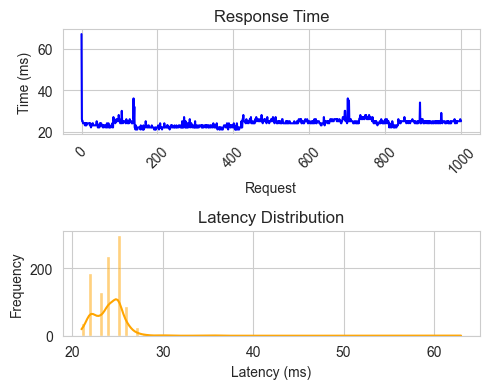

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(2, 1, figsize=(5, 4))

# Plot Response Time vs Request
axes[0].plot(df['elapsed'], label="Response Time per Request", color='blue')
axes[0].set_xlabel("Request")
axes[0].set_ylabel("Time (ms)")
axes[0].set_title("Response Time")
axes[0].tick_params(axis='x', rotation=45)

# Plot Latency Distribution
sns.histplot(df['Latency'], kde=True, color='orange', ax=axes[1])
axes[1].set_xlabel("Latency (ms)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Latency Distribution")

plt.tight_layout()
plt.show()
